
### 预测PM2.5

#### 数据集
+ train.csv:每个月前20天每个小时的气象资料（每小时有18种测资）共12个月
+ test.csv: 排除train.csv剩余的资料 取连续9小时的资料当作feature 预测第10小时的PM2.5值 总共240笔
+ sample.py 教程ppt对应的sample代码 用作参考
+ ans.csv test的answer

数据集保存在 HW01 文件夹中

In [1]:
# 导入相关的包
import csv, os
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import inv
import random
import math
import sys

In [2]:
def ada(X, Y, w, eta, iteration, lambdaL2):
    s_grad = np.zeros(len(X[0]))
    list_cost = []
    for i in range(iteration):
        hypo = np.dot(X,w)
        loss = hypo - Y
        cost = np.sum(loss**2)/len(X)
        list_cost.append(cost)

        grad = np.dot(X.T, loss)/len(X) + lambdaL2*w
        s_grad += grad**2
        ada = np.sqrt(s_grad)
        w = w - eta*grad/ada
    return w, list_cost

In [3]:
def SGD(X, Y, w, eta, iteration, lambdaL2):
    list_cost = []
    for i in range(iteration):
        hypo = np.dot(X,w)
        loss = hypo - Y
        cost = np.sum(loss**2)/len(X)
        list_cost.append(cost)

        rand = np.random.randint(0, len(X))
        grad = X[rand]*loss[rand]/len(X) + lambdaL2*w
        w = w - eta*grad
    return w, list_cost

In [4]:
def GD(X, Y, w, eta, iteration, lambdaL2):
    list_cost = []
    for i in range(iteration):
        hypo = np.dot(X,w)
        loss = hypo - Y
        cost = np.sum(loss**2)/len(X)
        list_cost.append(cost)

        grad = np.dot(X.T, loss)/len(X) + lambdaL2 * w
        w = w - eta*grad
    return w, list_cost

In [5]:
# 每一个维度储存一种污染物的咨询
data = []
for i in range(18):
    data.append([])

In [6]:
# 读取数据
n_row = 0
text = open('HW01/train.csv', 'r', encoding='big5')
row = csv.reader(text, delimiter=',')
for r in row:
    if n_row != 0:
        for i in range(3,27):
            if r[i] != "NR":
                data[(n_row-1)%18].append(float(r[i]))
            else:
                data[(n_row-1)%18].append(float(0))
    n_row = n_row + 1
text.close

<function TextIOWrapper.close>

In [7]:
#parse data to trainX and trainY
x = []
y = []
for i in range(12):
    for j in range(471):
        x.append([])
        for t in range(18):
            for s in range(9):
                x[471*i + j].append(data[t][480*i+j+s])
        y.append(data[9][480*i+j+9])
trainX = np.array(x) #每一行有9*18个数 每9个代表9天的某一种污染物
trainY = np.array(y)
trainX


array([[14. , 14. , 14. , ...,  2. ,  2. ,  0.5],
       [14. , 14. , 13. , ...,  2. ,  0.5,  0.3],
       [14. , 13. , 12. , ...,  0.5,  0.3,  0.8],
       ...,
       [17. , 18. , 19. , ...,  1.1,  1.4,  1.3],
       [18. , 19. , 18. , ...,  1.4,  1.3,  1.6],
       [19. , 18. , 17. , ...,  1.3,  1.6,  1.8]])

In [8]:
trainY

array([30., 41., 44., ..., 17., 24., 29.])

In [9]:
#parse test data

test_x = []
n_row = 0
text = open('HW01/test.csv' ,"r")
row = csv.reader(text , delimiter= ",")

for r in row:
    if n_row %18 == 0:
        test_x.append([])
        for i in range(2,11):
            test_x[n_row//18].append(float(r[i]) )
    else :
        for i in range(2,11):
            if r[i] !="NR":
                test_x[n_row//18].append(float(r[i]))
            else:
                test_x[n_row//18].append(0)
    n_row = n_row+1
text.close()
test_x = np.array(test_x)
test_x

array([[15. , 14. , 14. , ...,  2.5,  2.5,  2.3],
       [12. , 12. , 12. , ...,  2.1,  2.6,  1.5],
       [ 8.8, 12. , 15. , ...,  2.6,  1.8,  1.4],
       ...,
       [12. , 11. , 11. , ...,  1.8,  1.6,  0.6],
       [14. , 13. , 12. , ...,  1.6,  2.1,  1.8],
       [11. , 11. , 11. , ...,  0.6,  0.5,  0.5]])

In [10]:
#parse anser
ans_y = []
n_row = 0
text = open('HW01/ans.csv', "r")
row = csv.reader(text, delimiter=",")

for r in row:
    ans_y.append(r[1])

ans_y = ans_y[1:]
ans_y = np.array(list(map(int, ans_y)))


# add bias
test_x = np.concatenate((np.ones((test_x.shape[0],1)),test_x), axis=1)
trainX = np.concatenate((np.ones((trainX.shape[0],1)), trainX), axis=1)


#train data
w = np.zeros(len(trainX[0]))
w_sgd, cost_list_sgd = SGD(trainX, trainY, w, eta=0.0001, iteration=20000, lambdaL2=0)
# w_sgd50, cost_list_sgd50 = SGD(trainX, trainY, w, eta=0.0001, iteration=20000, lambdaL2=50)
w_ada, cost_list_ada = ada(trainX, trainY, w, eta=1, iteration=20000, lambdaL2=0)
# w_gd, cost_list_gd = SGD(trainX, trainY, w, eta=0.0001, iteration=20000, lambdaL2=0)

#close form
w_cf = inv(trainX.T.dot(trainX)).dot(trainX.T).dot(trainY)
cost_wcf = np.sum((trainX.dot(w_cf)-trainY)**2) / len(trainX)
hori = [cost_wcf for i in range(20000-3)]



#output testdata
y_ada = np.dot(test_x, w_ada)
y_sgd = np.dot(test_x, w_sgd)
y_cf = np.dot(test_x, w_cf)

#csv format
ans = []
for i in range(len(test_x)):
    ans.append(["id_"+str(i)])
    a = np.dot(w_ada,test_x[i])
    ans[i].append(a)

filename = "HW01/predict.csv"
text = open(filename, "w+")
s = csv.writer(text,delimiter=',',lineterminator='\n')
s.writerow(["id","value"])
for i in range(len(ans)):
    s.writerow(ans[i])
text.close()

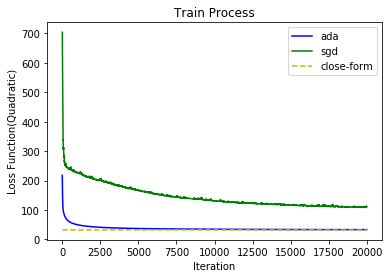

In [11]:
#plot training data with different gradiant method
plt.plot(np.arange(len(cost_list_ada[3:])), cost_list_ada[3:], 'b', label="ada")
plt.plot(np.arange(len(cost_list_sgd[3:])), cost_list_sgd[3:], 'g', label='sgd')
# plt.plot(np.arange(len(cost_list_sgd50[3:])), cost_list_sgd50[3:], 'c', label='sgd50')
# plt.plot(np.arange(len(cost_list_gd[3:])), cost_list_gd[3:], 'r', label='gd')
plt.plot(np.arange(len(cost_list_ada[3:])), hori, 'y--', label='close-form')
plt.title('Train Process')
plt.xlabel('Iteration')
plt.ylabel('Loss Function(Quadratic)')
plt.legend()
# plt.savefig(os.path.join(os.path.dirname(__file__), "HW01/TrainProcess"))
plt.show()

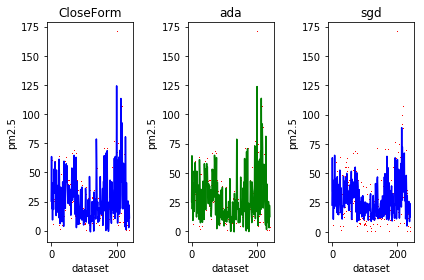

In [12]:
#plot fianl answer
plt.figure()
plt.subplot(131)
plt.title('CloseForm')
plt.xlabel('dataset')
plt.ylabel('pm2.5')
plt.plot(np.arange((len(ans_y))), ans_y, 'r,')
plt.plot(np.arange(240), y_cf, 'b')
plt.subplot(132)
plt.title('ada')
plt.xlabel('dataset')
plt.ylabel('pm2.5')
plt.plot(np.arange((len(ans_y))), ans_y, 'r,')
plt.plot(np.arange(240), y_ada, 'g')
plt.subplot(133)
plt.title('sgd')
plt.xlabel('dataset')
plt.ylabel('pm2.5')
plt.plot(np.arange((len(ans_y))), ans_y, 'r,')
plt.plot(np.arange(240), y_sgd, 'b')
plt.tight_layout()
#plt.savefig(os.path.join(os.path.dirname(__file__), "HWO1/Compare"))
plt.show()
